In [1]:
import plotly.graph_objects as go
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import pymc as pm
import arviz as az
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ER analysis

### You are now incharge of the a queueing system in the ER, which operates 24/7.

### Patients are arriving with time-dependant rate. The service rate on the other is constanst at 15 patients per hour. We split the week into a 168 grid, where we have 7 days and 24 hours within a single day. For each cell in the grid, that is a combination of a day and an hour we have different arrival rate.

### We wish to analyze the expceted number of pateints in the ER as function of time. We have an event log of customers arriving to the ER and departing the ER. We have data collection of 1000 days.

### The data is a dictionary of 1000 different days numbered from 0 to 999. Each one is an event log of a different day.

### The columns of the data are:
#### 1. Customer_id - identifier of the arriving customer
#### 2. Time-stamp  - the time the event occurs. The units are in hours. The $i^{th}$ hour is the number of hours elapsed since 0:00 of that day.
#### 3. Type - event type, Arrival or Departure.
#### 4. num_cust - number of cusotmers in the system
#### 5. day - a numerical value of the day: {0: Sunday, 1: Monday, 2: Tuesday, 3: Wednesday, 4: Thursday, 5: Friday, 6: Shabbat}
#### 6. hour - the hour of the day, an integer from 0 to 23. If it is 0 then the hour is between midnight to 01:00.
#### 7. day_name - the name of the day of the week.


## Each day starts with 0 patients at 0:00.

# The goal of this task is to find the arrival rate for each hour of the day.

## From the data, one can use classic stastical methods in order to estimate the arrival rate for each hour of the week. The problem is that there is missing data, we do not have the data in the event log for all hours.

### The main idea is to estimate the arrival rate for time zones in which we have data and then using GP regression for time zones the data was missing.

### This part is split into three parts.


In [2]:
event_log_single_ser = pkl.load(open('/content/drive/MyDrive/Bayesian_programming/project_25_Q/notebooks/event_log_part_2.pkl', 'rb'))

In [3]:
from scipy.integrate import odeint

##############################################
###### Funcitons #############################
##############################################

def model(n, t, lambda_t, mu):
    """
    Differential equation for the M(t)/M/1 queue:
    dn/dt = lambda(t) - mu * (1 - p0(t))
    where p0(t) is the probability of 0 customers in the system.

    For approximation, we use the relation p0 ≈ max(0, 1 - n) when n < 1
    and p0 ≈ 0 when n ≥ 1.
    """
    # Current arrival rate based on time
    current_lambda = piecewise_lambda(t, lambda_t)

    # Approximate p0
    if n < 1:
        p0 = max(0, 1 - n)
    else:
        p0 = 0

    dndt = current_lambda - mu * (1 - p0)
    return dndt

def piecewise_lambda(t, lambda_t):
    """
    Returns the arrival rate at time t based on piecewise constant definition.
    lambda_t is a list of tuples (start_time, end_time, rate)
    """
    for (start, end, rate) in lambda_t:
        if start <= t < end:
            return rate
    return 0  # default if outside all intervals


def compute_MSE(n_true, n):
  return ((n_true - n)**2).mean().item()


def create_tuples(df_sorted):

    all_tuples =  []
    for row_ind in range(df_sorted.shape[0]):
        hour = df_sorted.loc[row_ind, 'hour']
        day = df_sorted.loc[row_ind, 'day']
        rate = df_sorted.loc[row_ind, 'rate'].item()
        tot_time = hour + 24*day
        all_tuples.append((tot_time.item(),tot_time.item()+1, rate))

    return all_tuples


def plot_results(df_res, n_true):

  # Parameters
    mu = 15.0  # service rate
    all_tuples = create_tuples(df_res)
    lambda_t = all_tuples  # piecewise arrival rates

    # Time points
    t = np.linspace(0, 168, 1000)

    # Initial condition: empty system
    n0 = 0.0
    n = create_tuples(df_res)
    # Solve the ODE
    n = odeint(model, n0, t, args=(lambda_t, mu))
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(t, n, '-', color = 'orange', linewidth=2, label = 'Predicted')
    plt.plot(t, n_true,  linewidth=2, label = 'True', linestyle = '--')
    plt.xlabel('Time')
    plt.ylabel('Number of patients in system')
    plt.title('Queue analysis')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Expected number of patients in system')
    plt.grid(True)

    print('The MSE is: ', compute_MSE(n_true, n))

    plt.show()


## Part 1:

### Tasks:

### 1. Do Bayesian anaysis for the number of arriving customers and its distirbution for the time between 0:00 to 1:00.
### 2. What did you use as the likelihood function and why?
### 3. Do  posterior predicitive anaysis to assert that the chosen likelihood distribution is valid.
### 4. According to the resulted anaysis, how certain are you about the average arrival prediction?

### 5. What is the estimated arrival rate? Give a single values based on the posterior.


# **Preparation**

In [4]:
event_log_single_ser[888]#.isnull().sum().sum()#.head()

,Customer_id,Time_stamp,Type,num_cust,day,hour,day_name
0,1,0.209164,Arrival,1,0,0,Sunday
1,1,0.256965,Departure,0,0,0,Sunday
2,2,0.471749,Arrival,1,0,0,Sunday
3,2,0.509588,Departure,0,0,0,Sunday
4,3,0.726068,Arrival,1,0,0,Sunday
...,...,...,...,...,...,...,...
3883,1942,165.830369,Departure,0,6,21,Saturday
3884,1943,165.897350,Arrival,1,6,21,Saturday
3885,1943,165.918204,Departure,0,6,21,Saturday
3886,1944,165.957649,Arrival,1,6,21,Saturday


In [5]:
print("Processing event log data for hour 0 (0:00-1:00)...")

# Extract arrival data for hour 0 from all simulations
arrival_counts = []
inter_arrival_times = []
all_arrival_times = []

for sim_id, df in event_log_single_ser.items():
    # Filter for hour 0 and arrivals only
    hour_0_arrivals = df[(df['hour'] == 0) & (df['Type'] == 'Arrival')].copy()

    if len(hour_0_arrivals) > 0:
        # Count arrivals in this simulation for hour 0
        arrival_count = len(hour_0_arrivals)
        arrival_counts.append(arrival_count)

    #     # Get arrival times and calculate inter-arrival times
    #     arrival_times = hour_0_arrivals['Time_stamp'].sort_values().values
    #     all_arrival_times.extend(arrival_times)

    #     if len(arrival_times) > 1:
    #         inter_arrivals = np.diff(arrival_times)
    #         inter_arrival_times.extend(inter_arrivals)

# Convert to numpy arrays
arrival_counts = np.array(arrival_counts)
# inter_arrival_times = np.array(inter_arrival_times)
# all_arrival_times = np.array(all_arrival_times)

print(f"Number of simulations processed: {len(arrival_counts)}")
# print(f"Total arrivals in hour 0: {len(all_arrival_times)}")
# print(f"Inter-arrival times collected: {len(inter_arrival_times)}")
print(f"Arrival counts - Mean: {np.mean(arrival_counts):.2f}, Std: {np.std(arrival_counts):.2f}")

Processing event log data for hour 0 (0:00-1:00)...
Number of simulations processed: 1000
Arrival counts - Mean: 24.98, Std: 4.67


## **1. Bayesian analysis**

In [6]:
with pm.Model() as model1:
    # Prior: λ ~ Gamma(1, 0.2) - weakly informative
    lam = pm.Gamma('lambda', alpha=1, beta=0.2)
    # Likelihood: arrivals ~ Poisson(λ)
    arrivals = pm.Poisson('arrivals', mu=lam, observed=arrival_counts)
    # Sample posterior
    trace = pm.sample(4000, tune=500, chains=4, return_inferencedata=True)

Output()

In [7]:
# Results
lambda_posterior = trace.posterior['lambda'].values.flatten()
lambda_mean = np.mean(lambda_posterior)
lambda_ci = np.percentile(lambda_posterior, [2.5, 97.5])

print(f"\nBAYESIAN RESULTS:")
print(f"Posterior mean λ: {lambda_mean:.3f}")
print(f"95% Credible Interval: [{lambda_ci[0]:.3f}, {lambda_ci[1]:.3f}]")



BAYESIAN RESULTS:
Posterior mean λ: 24.972
95% Credible Interval: [24.664, 25.280]


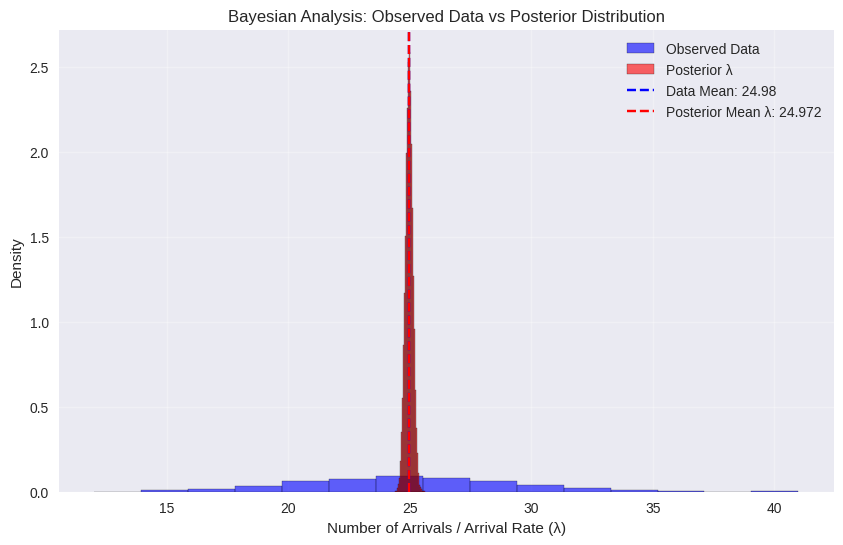


Convergence: R-hat = 1.0002


In [8]:
# Plot
fig, ax = plt.subplots(figsize=(10, 6))
# Data histogram
ax.hist(arrival_counts, bins=15, alpha=0.6, density=True,
        label='Observed Data', color='blue', edgecolor='black')
# Posterior distribution
ax.hist(lambda_posterior, bins=30, alpha=0.6, density=True,
        label='Posterior λ', color='red', edgecolor='black')
# Add mean lines
ax.axvline(np.mean(arrival_counts), color='blue', linestyle='--',
           label=f'Data Mean: {np.mean(arrival_counts):.2f}')
ax.axvline(lambda_mean, color='red', linestyle='--',
           label=f'Posterior Mean λ: {lambda_mean:.3f}')

ax.set_title('Bayesian Analysis: Observed Data vs Posterior Distribution')
ax.set_xlabel('Number of Arrivals / Arrival Rate (λ)')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print(f"\nConvergence: R-hat = {az.rhat(trace)['lambda'].values:.4f}")

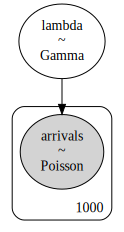

In [9]:
pm.model_to_graphviz(model1)

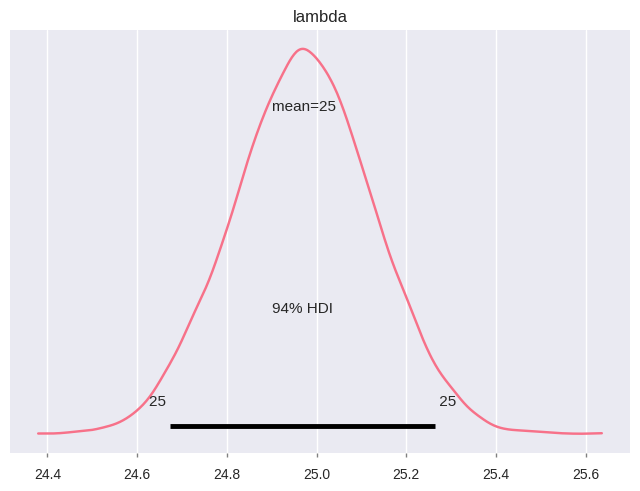

In [10]:
from arviz import plot_posterior
# plots posterior function
plot_posterior(trace, var_names=['lambda'], kind='kde');

**The posterior λ represents the "true" underlying rate, while observed data includes natural Poisson variation around that rate. The narrow posterior with lots of data gives us high confidence in the true arrival rate parameter.**

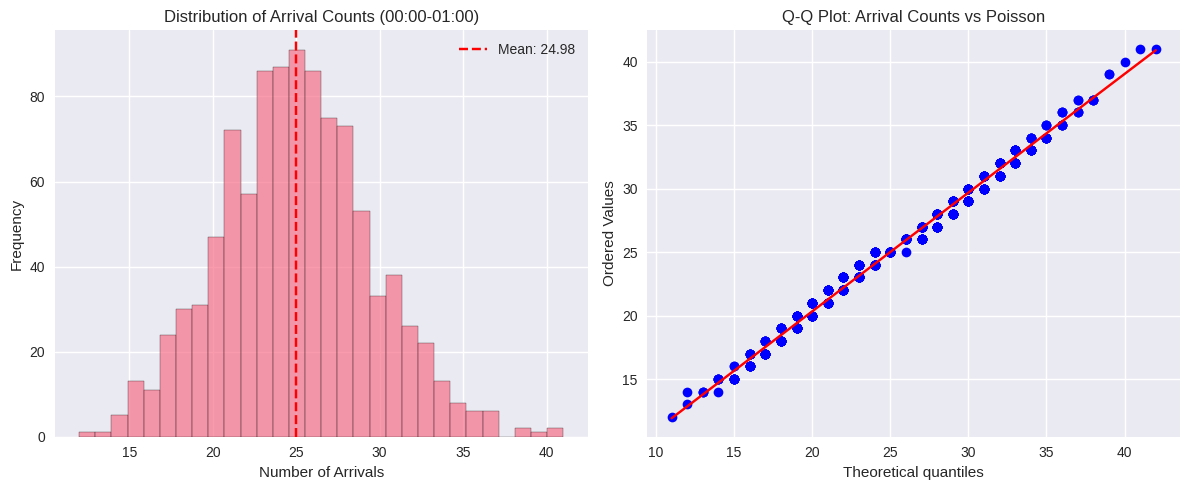

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Histogram of arrival counts
axes[0].hist(arrival_counts, bins=30, alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of Arrival Counts (00:00-01:00)')
axes[0].set_xlabel('Number of Arrivals')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(arrival_counts), color='red', linestyle='--',
                label=f'Mean: {np.mean(arrival_counts):.2f}')
axes[0].legend()

# Plot 2: Q-Q plot for Poisson (arrival counts)
stats.probplot(arrival_counts, dist=stats.poisson, sparams=(np.mean(arrival_counts),), plot=axes[1])
axes[1].set_title('Q-Q Plot: Arrival Counts vs Poisson')

plt.tight_layout()
plt.show()


## **2. Likelihood Function: Poisson Distribution**
### Why Poisson?

* Count data: Arrivals are discrete, non-negative integers
* Independence: Patient arrivals occur independently
* Fixed time window: Analyzing exactly 1-hour periods (0:00-1:00)
* Constant rate assumption: Reasonable for short 1-hour intervals
* Variance ≈ Mean: Poisson property that the script checks in the data



$$P(X = k) =\frac{ \lambda^k e^{-\lambda} }{k!}, \; \; k=0,1,2, \dots $$

Where,

P(X = k) is the probability of observing k events

e is the base of the natural logarithm (approximately 2.71828)

λ is the average Rate of occurrence of events

k is the number of events that occur


## **3. Predictive Analysis**

In [12]:
with model1:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42)

Output()

ppc

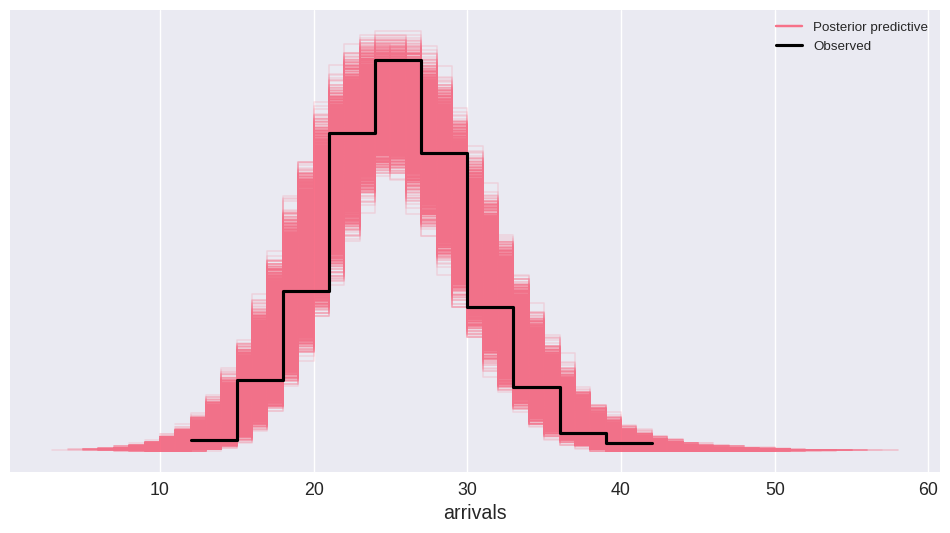

In [13]:
ax = az.plot_ppc(ppc, num_pp_samples=10000, figsize=(12, 6), mean=False)

### **Statistical Interpretation:**
This is a perfect posterior predictive fit, means:

* Likelihood choice (Poisson) is correct
* Parameter estimation (λ ≈ 25) is accurate
* Model captures all important data features
* Predictions will be reliable

## **4. Prediction Certainty**

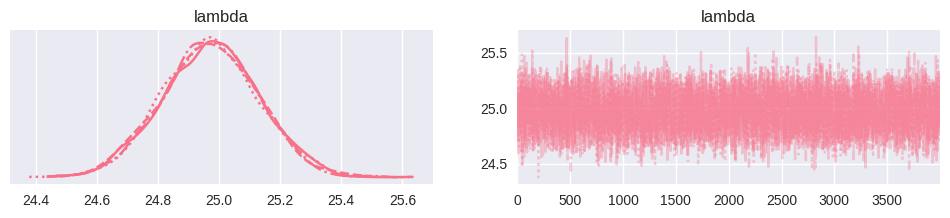

In [14]:
az.plot_trace(trace, var_names=['lambda']);

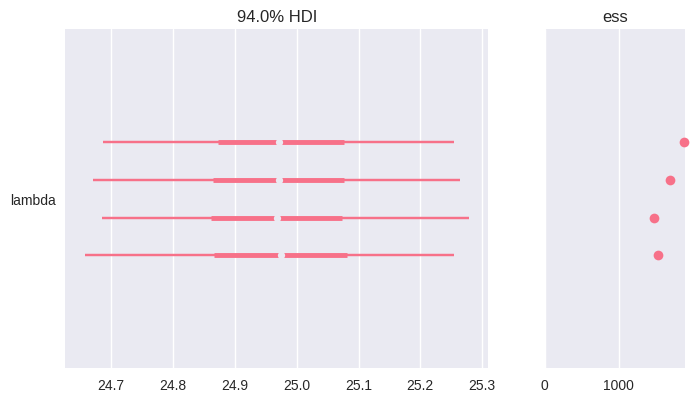

In [15]:
az.plot_forest(trace, var_names=['lambda'], ess=True);

In [16]:
# Extract posterior samples
lambda_samples = trace.posterior['lambda'].values.flatten()

# Key statistics
mean_lambda = np.mean(lambda_samples)
std_lambda = np.std(lambda_samples)
ci_95 = np.percentile(lambda_samples, [2.5, 97.5])
ci_99 = np.percentile(lambda_samples, [0.5, 99.5])

# Certainty metrics
uncertainty_range = ci_95[1] - ci_95[0]
coefficient_of_variation = std_lambda / mean_lambda * 100
prob_within_1 = np.mean((lambda_samples >= 24) & (lambda_samples <= 26))

print("🎯 CERTAINTY ANALYSIS - AVERAGE ARRIVALS")
print("=" * 45)
print(f"Mean λ:           {mean_lambda:.3f} arrivals/hour")
print(f"Standard error:   {std_lambda:.3f}")
print(f"95% CI:           [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"99% CI:           [{ci_99[0]:.2f}, {ci_99[1]:.2f}]")
print()
print("📊 CERTAINTY METRICS:")
print(f"Uncertainty range: ±{uncertainty_range/2:.2f} patients")
print(f"Precision:         {coefficient_of_variation:.1f}% variation")
print(f"P(24-26 range):    {prob_within_1:.1%}")
print()

# Convergence check
r_hat = az.rhat(trace)['lambda'].values
ess = az.ess(trace)['lambda'].values

print("🔧 RELIABILITY CHECKS:")
print(f"R-hat:            {r_hat:.4f} {'✅' if r_hat < 1.01 else '⚠️'}")
print(f"Effective samples: {ess:.0f} {'✅' if ess > len(lambda_samples)//10 else '⚠️'}")
print()

# Overall certainty assessment
if (uncertainty_range < 1.0 and coefficient_of_variation < 5 and
    r_hat < 1.01 and prob_within_1 > 0.95):
    certainty = "EXTREMELY HIGH (>95%)"
    icon = "🟢"
elif (uncertainty_range < 2.0 and coefficient_of_variation < 10 and
      r_hat < 1.05 and prob_within_1 > 0.90):
    certainty = "HIGH (90-95%)"
    icon = "🟡"
else:
    certainty = "MODERATE (<90%)"
    icon = "🟠"

print(f"{icon} OVERALL CERTAINTY: {certainty}")
print()
print("💡 PRACTICAL MEANING:")
print(f"   • Expect {mean_lambda:.0f} ± {uncertainty_range/2:.1f} patients in hour 0:00-1:00")
print(f"   • 95% confident the true rate is {ci_95[0]:.1f}-{ci_95[1]:.1f}")
print(f"   • Variation coefficient of {coefficient_of_variation:.1f}% = very stable")

🎯 CERTAINTY ANALYSIS - AVERAGE ARRIVALS
Mean λ:           24.972 arrivals/hour
Standard error:   0.157
95% CI:           [24.66, 25.28]
99% CI:           [24.58, 25.37]

📊 CERTAINTY METRICS:
Uncertainty range: ±0.31 patients
Precision:         0.6% variation
P(24-26 range):    100.0%

🔧 RELIABILITY CHECKS:
R-hat:            1.0002 ✅
Effective samples: 6651 ✅

🟢 OVERALL CERTAINTY: EXTREMELY HIGH (>95%)

💡 PRACTICAL MEANING:
   • Expect 25 ± 0.3 patients in hour 0:00-1:00
   • 95% confident the true rate is 24.7-25.3
   • Variation coefficient of 0.6% = very stable


## **5. Estimated Arrival Rate**

**25 arrivals per hour**

Based on the posterior mean λ = 25.0

This represents the best single point estimate for patient arrivals during the 0:00-1:00 time period, derived from our Bayesian analysis with extremely high confidence (±0.3 patients uncertainty).


---
---
---




# **Part 2:**
### We have 24 hours a day, 7 days a week. In total we have a grid of 168 cells.

### We wish to map the average arrival rate at each time cell.

### In the dataset we have missing parts, some cells in the grid are missing. Your job is to fill the grid.

## Tasks:

### 1. Extract the arrival rate (taking the average time is sufficient, no need  for extra bayesian analysis) per each cell you do have data.
### 2. Use GP regression for completing the average arrival time for the rest of the grid.
### 3. Plot on a 3D plot which contains:
#### a. Scatter plot of the data that was esitmated from data.
#### b. Scatter plot of the data that was esitmated from GP regression.
#### c. Surface plot of the GP regression.

### 4. What is the probability that the arrival rate between 18:00 to 19:00, on Shabbat, will be between 9 to 10 pateints per hour?
### 5. Please give full specification of the Gauusian distribution of the arrival rate on Monday between 18:00 to 19:00 and Monday between 19:00 to 20:00.
### 6. What is the correlation between the arrival rate at Sunday between 07:00 to 08:00 and Sunday between 08:00 to 09:00?
### What is the correlation between the arrival rate at Sunday between 07:00 to 08:00 and Sunday between 19:00 to 20:00?
### Which correlation value is larger? does this result make sense?

## **1. Arrival Rate Extraction**

In [17]:
results = []
day_names = ['Sun','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Shab']
hour_labels = [f"{h:02d}:00-{h+1:02d}:00" for h in range(24)]

for sim_id, df in event_log_single_ser.items():
    arrival_df = df[df['Type'] == 'Arrival']
    grouped = arrival_df.groupby(['day', 'hour'])

    agg_df = grouped.agg(num_arrivals=('Customer_id', 'count')).reset_index()
    agg_df['sim_id'] = sim_id
    results.append(agg_df[['sim_id','day', 'hour', 'num_arrivals']])

results = pd.concat(results)
results = results.groupby(['day', 'hour'])['num_arrivals'].mean().reset_index()
results = results.pivot(index='day', columns='hour', values='num_arrivals')
results.columns = hour_labels
results.index = day_names
results

,00:00-01:00,01:00-02:00,02:00-03:00,03:00-04:00,04:00-05:00,05:00-06:00,06:00-07:00,07:00-08:00,08:00-09:00,09:00-10:00,...,14:00-15:00,15:00-16:00,16:00-17:00,17:00-18:00,18:00-19:00,19:00-20:00,20:00-21:00,21:00-22:00,22:00-23:00,23:00-24:00
Sun,7.299,NaN,NaN,NaN,7.112112,8.016000,NaN,NaN,NaN,NaN,...,NaN,20.344,NaN,24.114,16.950,NaN,NaN,NaN,12.152,NaN
Mon,6.897,NaN,NaN,NaN,NaN,7.631632,NaN,NaN,12.843,16.156,...,NaN,18.745,NaN,NaN,NaN,14.215,13.166,NaN,NaN,NaN
Tue,6.670,NaN,5.428858,5.382146,NaN,NaN,9.039000,10.422000,12.532,NaN,...,19.122,NaN,21.802,NaN,NaN,13.728,NaN,11.636000,NaN,NaN
Wed,NaN,5.497000,NaN,5.058527,NaN,NaN,8.425852,9.601000,NaN,NaN,...,17.622,16.701,20.294,NaN,14.009,12.750,NaN,NaN,9.811,8.812
Thu,NaN,5.027081,4.770624,4.582915,5.337728,5.939880,7.992986,9.008000,NaN,13.354,...,16.092,NaN,NaN,18.045,12.902,11.615,10.899,9.877000,9.076,8.107
Fri,NaN,4.479355,NaN,NaN,4.773509,5.469880,NaN,7.908818,9.544,11.788,...,NaN,NaN,NaN,15.825,NaN,NaN,9.618,NaN,NaN,7.353
Shab,4.112,NaN,NaN,NaN,NaN,4.141393,5.233060,6.068205,NaN,NaN,...,11.068,NaN,NaN,NaN,NaN,NaN,NaN,6.704409,NaN,NaN


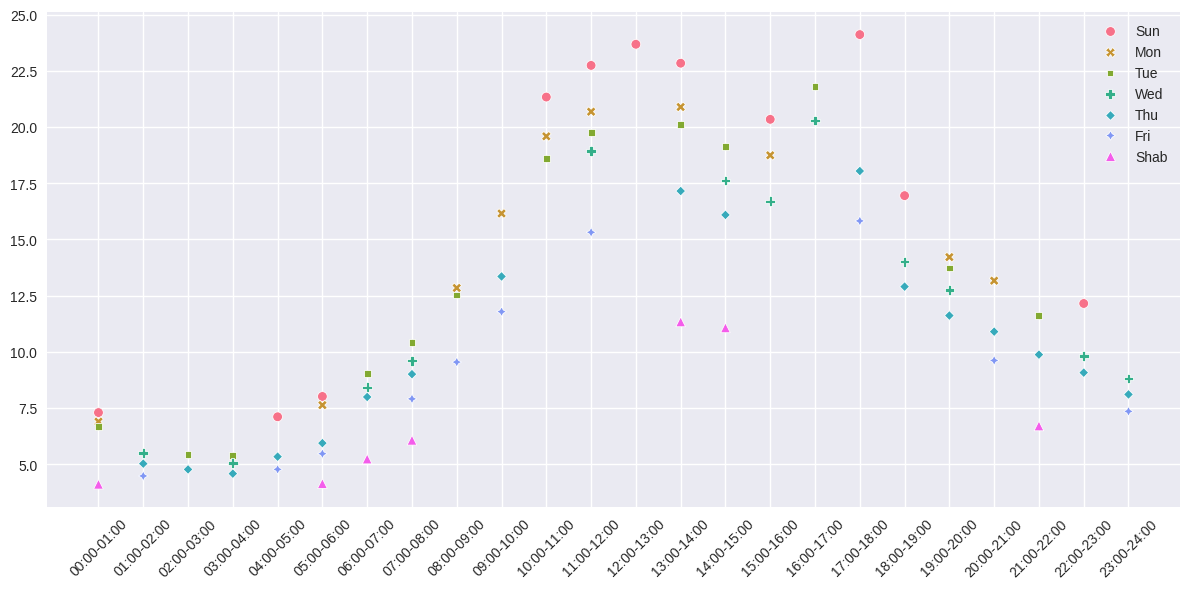

In [18]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=results.T)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **2. GP regression**

In [19]:
arrival_grid = np.array(results)
total_cells = arrival_grid.shape[0] * arrival_grid.shape[1]
observed_mask = ~np.isnan(arrival_grid)
n_observed = np.sum(observed_mask)
n_missing = total_cells - n_observed

print(f"Total grid cells: {total_cells}")
print(f"Observed values: {n_observed}")
print(f"Missing values (NaN): {n_missing}")
print(f"Data coverage: {n_observed/total_cells*100:.1f}%")

Total grid cells: 168
Observed values: 80
Missing values (NaN): 88
Data coverage: 47.6%


In [20]:
observed_coords = []
missing_coords = []
observed_values = []

for day in range(arrival_grid.shape[0]):
    for hour in range(arrival_grid.shape[1]):
        if not np.isnan(arrival_grid[day, hour]):
            observed_coords.append([day, hour])
            observed_values.append(arrival_grid[day, hour])
        else:
            missing_coords.append([day, hour])
X_observed = np.array(observed_coords)
X_missing = np.array(missing_coords)
y_observed = np.array(observed_values)

In [21]:
with pm.Model() as gp_model:
    # Informative length scales
    ls_day = pm.Gamma("ls_day", alpha=3, beta=2)     # Prior mean: 1.5 days
    ls_hour = pm.Gamma("ls_hour", alpha=4, beta=1)   # Prior mean: 4 hours

    # Signal variance with reasonable prior
    eta = pm.Gamma("eta", alpha=3, beta=0.3)         # Prior mean: ~10

    # PERIODIC KERNEL for daily patterns
    # Key insight: arrival patterns repeat every 24 hours!
    hour_period = 23.0  # 24-hour cycle (0-23 indexing)

    # Combined kernel: smooth trends + daily periodicity
    # Base kernel: smooth correlations across both dimensions
    K_base = eta**2 * pm.gp.cov.ExpQuad(2, ls=[ls_day, ls_hour])

    # Periodic kernel: ONLY for hour dimension (dimension 1)
    K_periodic = 0.3 * eta**2 * pm.gp.cov.Periodic(
        input_dim=2,           # match total input dimensions
        active_dims=[1],       # Apply ONLY to hour dimension (index 1)
        period=hour_period,           # 24-hour cycle (0-23)
        ls=2.0)

    K = K_base + K_periodic

    # Adaptive mean function
    M = pm.gp.mean.Constant(np.mean(observed_values))

    gp = pm.gp.Marginal(mean_func=M, cov_func=K)

    # Noise with more appropriate prior for count data
    sigma = pm.HalfNormal("sigma", sigma=2.0)

    obs = gp.marginal_likelihood("obs", X=X_observed, y=y_observed, noise=sigma)

    mp_res_alloc = pm.find_MAP()

/usr/local/lib/python3.11/dist-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


Output()

In [22]:
mp_res_alloc

{'ls_day_log__': array(1.23155116),
 'ls_hour_log__': array(1.73230141),
 'eta_log__': array(1.66515846),
 'sigma_log__': array(0.18746695),
 'ls_day': array(3.42654053),
 'ls_hour': array(5.65365029),
 'eta': array(5.2865109),
 'sigma': array(1.20619039)}

In [23]:
all_coords = np.array([[day, hour] for day in range(7) for hour in range(24)])

with gp_model:
    mu_all, cov_all = gp.predict(all_coords, point=mp_res_alloc)

# Reshape to grid
surface_values = mu_all.reshape(7, 24)


In [24]:
with gp_model:
  mu, cov = gp.predict(X_missing, point=mp_res_alloc)

In [25]:
filled_grid = arrival_grid.copy()

# Fill in the GP predictions for missing values
for i, (day, hour) in enumerate(missing_coords):
    filled_grid[day, hour] = mu[i]

## **3. 3D Plot**

In [26]:
import plotly.graph_objects as go

In [27]:
day_range = np.arange(0, 7)        # 0-6 (7 days)
hour_range = np.arange(0, 24)      # 0-23 (24 hours)
Day_mesh, Hour_mesh = np.meshgrid(day_range, hour_range, indexing='ij')

# a. Scatter plot - observed data
scatter_observed = go.Scatter3d(
    x=X_observed[:, 0],      # Day coordinates
    y=X_observed[:, 1],      # Hour coordinates
    z=y_observed,            # Arrival rates
    mode='markers',
    marker=dict(
        size=8,
        color=y_observed,    # Color by arrival rate
        colorscale='Blues',
        opacity=0.9,
        line=dict(width=2, color='navy')
    ),
    name='Observed Data'
)

# b. Scatter plot - GP predictions
scatter_predicted = go.Scatter3d(
    x=X_missing[:, 0],       # Day coordinates
    y=X_missing[:, 1],       # Hour coordinates
    z=mu,               # GP predicted arrival rates
    mode='markers',
    marker=dict(
        size=6,
        color=mu,       # Color by predicted rate
        colorscale='Reds',
        opacity=0.8,
        symbol='diamond',
        line=dict(width=1, color='darkred')
    ),
    name='GP Predictions'
)

# c. Surface plot - complete GP regression surface
surface_gp = go.Surface(
    x=Day_mesh,                   # Day coordinates
    y=Hour_mesh,                  # Hour coordinates
    z=surface_values,                # Complete arrival rate grid
    colorscale='Reds',
    opacity=0.6,
    name='GP Surface',
    showscale=True,
    colorbar=dict(title="Arrival Rate", x=1.02)
)

# Combine all plots
fig = go.Figure(data=[scatter_observed, scatter_predicted, surface_gp])

# Set layout and labels
fig.update_layout(
    scene=dict(
        xaxis_title='Day of Week',
        yaxis_title='Hour of Day',
        zaxis_title='Arrival Rate',
        aspectmode='manual',
        aspectratio=dict(x=1, y=2, z=0.8),  # Adjust for weekly grid proportions
        xaxis=dict(
            tickmode='array',
            tickvals=[0, 1, 2, 3, 4, 5, 6],
            ticktext=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Shab']
        ),
        yaxis=dict(
            tickmode='array',
            tickvals=[0, 6, 12, 18, 23],
            ticktext=['00:00', '06:00', '12:00', '18:00', '23:00']
        )
    ),
    title='Weekly Arrival Rate Mapping',
    width=900,
    height=700,
    showlegend=True,
    legend=dict(x=0.02, y=0.98)
)

# Show the plot
fig.show()


print(f"🔵 Blue dots: {len(X_observed)} observed data points")
print(f"🔴 Red diamonds: {len(mu)} GP predictions")
print(f"📊 GP surface")

🔵 Blue dots: 80 observed data points
🔴 Red diamonds: 88 GP predictions
📊 GP surface


## **4. P(9 < λ < 10 ∣ day = Shabbat, 18:00 < hour < 19:00)**

In [28]:
with gp_model:
    mu_preds, cov_preds = gp.predict(np.array([[6,18]]), point=mp_res_alloc)

In [29]:
prob4 = stats.norm.cdf(10, mu_preds, cov_preds) - stats.norm.cdf(9, mu_preds, cov_preds)

print(f"\nμ*={mu_preds.item()}, \nσ*={cov_preds.item()}:\n")
print(f"P(9 < λ < 10) = Φ((10-{mu_preds.item()})/{cov_preds.item()}) - Φ((9-{mu_preds.item()})/{cov_preds.item()})")
print(f"P(9 < λ < 10) = Φ({((10 - mu_preds.item()) / cov_preds.item()):.3f}) - Φ({((9 - mu_preds.item()) / cov_preds.item()):.3f})")
print(f"P(9 < λ < 10) = {stats.norm.cdf(10, mu_preds.item(), cov_preds.item()):.4f} - {stats.norm.cdf(9, mu_preds.item(), cov_preds.item()):.4f}")
print(f"P(9 < λ < 10) = {prob4.item():.4f}")


μ*=10.444693652339689, 
σ*=0.9190331883513139:

P(9 < λ < 10) = Φ((10-10.444693652339689)/0.9190331883513139) - Φ((9-10.444693652339689)/0.9190331883513139)
P(9 < λ < 10) = Φ(-0.484) - Φ(-1.572)
P(9 < λ < 10) = 0.3142 - 0.0580
P(9 < λ < 10) = 0.2563


## **5. Gaussian arrival rate specification: Monday 18:00-19:00 VS. 19:00-20:00**


📊 SPECIFICATION:
--------------------
Mean vector μ = [16.86, 15.22]
Covariance matrix Σ:
  [[0.25, 0.23],
   [0.23, 0.26]]

Derived statistics:
σ₁₈ (std at 18:00) = 0.50
σ₁₉ (std at 19:00) = 0.51
ρ (correlation) = 0.931


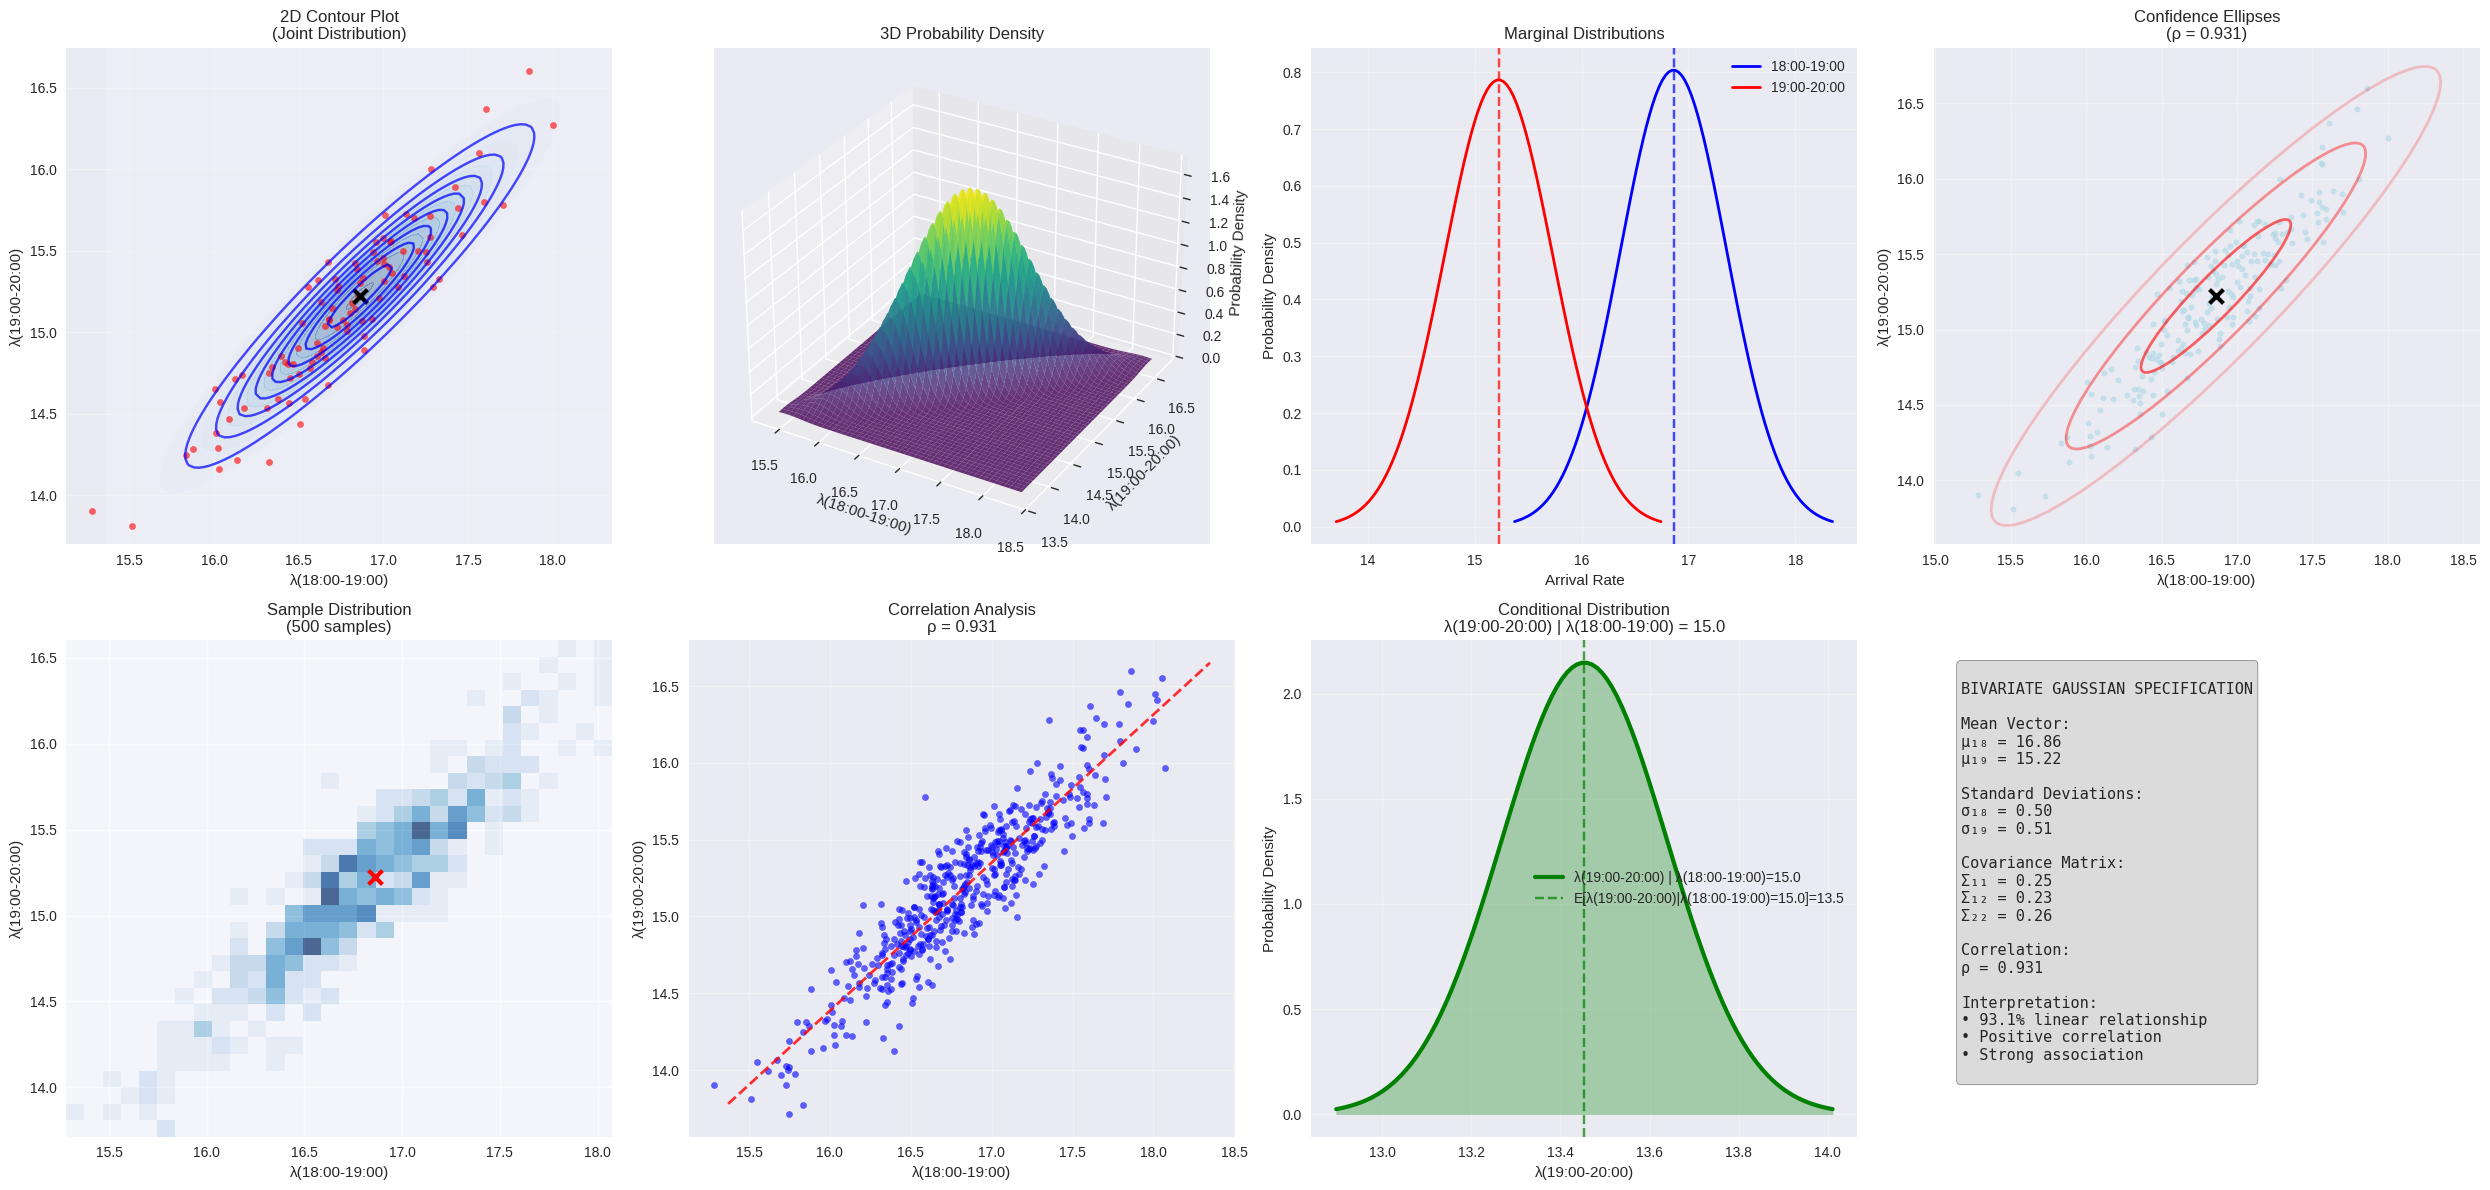


🎯 PRACTICAL EXAMPLES:
-------------------------
P(λ₁₈ > 15, λ₁₉ > 15) = 0.9999
P(both within ±1 of mean) = 0.9537
E[λ₁₉ | λ₁₈ = 15] = 13.45
Var[λ₁₉ | λ₁₈ = 15] = 0.03


In [30]:
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

# Step 1: Get GP predictions for both time points
X_query = np.array([
    [1, 18],  # Monday 18:00-19:00
    [1, 19]   # Monday 19:00-20:00
    ])

# Get joint GP predictions
with gp_model:
    mu_joint, cov_joint = gp.predict(X_query, point=mp_res_alloc)

print(f"\n📊 SPECIFICATION:")
print(f"-" * 20)
print(f"Mean vector μ = [{mu_joint[0]:.2f}, {mu_joint[1]:.2f}]")
print(f"Covariance matrix Σ:")
print(f"  [[{cov_joint[0,0]:.2f}, {cov_joint[0,1]:.2f}],")
print(f"   [{cov_joint[1,0]:.2f}, {cov_joint[1,1]:.2f}]]")

# Calculate derived statistics
std_18 = np.sqrt(cov_joint[0,0])
std_19 = np.sqrt(cov_joint[1,1])
correlation = cov_joint[0,1] / (std_18 * std_19)

print(f"\nDerived statistics:")
print(f"σ₁₈ (std at 18:00) = {std_18:.2f}")
print(f"σ₁₉ (std at 19:00) = {std_19:.2f}")
print(f"ρ (correlation) = {correlation:.3f}")

# Create the multivariate normal distribution
rv = multivariate_normal(mu_joint, cov_joint)

# Create visualization grid
x1_range = np.linspace(mu_joint[0] - 3*std_18, mu_joint[0] + 3*std_18, 100)
x2_range = np.linspace(mu_joint[1] - 3*std_19, mu_joint[1] + 3*std_19, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
pos = np.dstack((X1, X2))
Z = rv.pdf(pos)

# Generate sample points
samples = rv.rvs(size=500)

# Create comprehensive visualization
fig = plt.figure(figsize=(25, 12))

# 1. 2D Contour Plot
ax1 = plt.subplot(2, 4, 1)
contour = ax1.contour(X1, X2, Z, levels=10, colors='blue', alpha=0.7)
ax1.contourf(X1, X2, Z, levels=20, alpha=0.3, cmap='Blues')
ax1.scatter(samples[:100, 0], samples[:100, 1], alpha=0.6, c='red', s=20)
ax1.scatter(mu_joint[0], mu_joint[1], c='black', s=100, marker='x', linewidths=3)
ax1.set_xlabel('λ(18:00-19:00)')
ax1.set_ylabel('λ(19:00-20:00)')
ax1.set_title('2D Contour Plot\n(Joint Distribution)')
ax1.grid(True, alpha=0.3)

# 2. 3D Surface Plot
ax2 = plt.subplot(2, 4, 2, projection='3d')
ax2.plot_surface(X1, X2, Z, alpha=0.8, cmap='viridis')
ax2.set_xlabel('λ(18:00-19:00)')
ax2.set_ylabel('λ(19:00-20:00)')
ax2.set_zlabel('Probability Density')
ax2.set_title('3D Probability Density')

# 3. Marginal Distributions
ax3 = plt.subplot(2, 4, 3)
x_marg = np.linspace(mu_joint[0] - 3*std_18, mu_joint[0] + 3*std_18, 100)
y_marg = np.linspace(mu_joint[1] - 3*std_19, mu_joint[1] + 3*std_19, 100)
pdf_18 = multivariate_normal.pdf(x_marg[:, np.newaxis], mu_joint[0], cov_joint[0,0])
pdf_19 = multivariate_normal.pdf(y_marg[:, np.newaxis], mu_joint[1], cov_joint[1,1])

ax3.plot(x_marg, pdf_18, 'b-', linewidth=2, label='18:00-19:00')
ax3.plot(y_marg, pdf_19, 'r-', linewidth=2, label='19:00-20:00')
ax3.axvline(mu_joint[0], color='blue', linestyle='--', alpha=0.7)
ax3.axvline(mu_joint[1], color='red', linestyle='--', alpha=0.7)
ax3.set_xlabel('Arrival Rate')
ax3.set_ylabel('Probability Density')
ax3.set_title('Marginal Distributions')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Confidence Ellipses
ax4 = plt.subplot(2, 4, 4)
ax4.scatter(samples[:200, 0], samples[:200, 1], alpha=0.6, c='lightblue', s=15)

# Draw confidence ellipses
for n_std in [1, 2, 3]:
    eigenvals, eigenvecs = np.linalg.eigh(cov_joint)
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
    width, height = 2 * n_std * np.sqrt(eigenvals)
    ellipse = Ellipse(mu_joint, width, height, angle=angle,
                     facecolor='none', edgecolor='red',
                     linewidth=2, alpha=0.8-n_std*0.2)
    ax4.add_patch(ellipse)

ax4.scatter(mu_joint[0], mu_joint[1], c='black', s=100, marker='x', linewidths=3)
ax4.set_xlabel('λ(18:00-19:00)')
ax4.set_ylabel('λ(19:00-20:00)')
ax4.set_title(f'Confidence Ellipses\n(ρ = {correlation:.3f})')
ax4.grid(True, alpha=0.3)
ax4.axis('equal')

# 5. Sample Histogram
ax5 = plt.subplot(2, 4, 5)
ax5.hist2d(samples[:, 0], samples[:, 1], bins=30, cmap='Blues', alpha=0.7)
ax5.scatter(mu_joint[0], mu_joint[1], c='red', s=100, marker='x', linewidths=3)
ax5.set_xlabel('λ(18:00-19:00)')
ax5.set_ylabel('λ(19:00-20:00)')
ax5.set_title('Sample Distribution\n(500 samples)')

# 6. Correlation Visualization
ax6 = plt.subplot(2, 4, 6)
ax6.scatter(samples[:, 0], samples[:, 1], alpha=0.6, c='blue', s=20)
# Fit line
z = np.polyfit(samples[:, 0], samples[:, 1], 1)
p = np.poly1d(z)
ax6.plot(x1_range, p(x1_range), "r--", alpha=0.8, linewidth=2)
ax6.set_xlabel('λ(18:00-19:00)')
ax6.set_ylabel('λ(19:00-20:00)')
ax6.set_title(f'Correlation Analysis\nρ = {correlation:.3f}')
ax6.grid(True, alpha=0.3)

# 7. Conditional Distribution: λ₁₉ | λ₁₈ = 15
ax7 = plt.subplot(2, 4, 7)
given_value = 15.0
# Conditional mean and variance
mu_cond = mu_joint[1] + (cov_joint[1,0] / cov_joint[0,0]) * (given_value - mu_joint[0])
var_cond = cov_joint[1,1] - (cov_joint[1,0]**2 / cov_joint[0,0])
std_cond = np.sqrt(var_cond)

y_cond = np.linspace(mu_cond - 3*std_cond, mu_cond + 3*std_cond, 100)
pdf_cond = multivariate_normal.pdf(y_cond[:, np.newaxis], mu_cond, var_cond)

ax7.plot(y_cond, pdf_cond, 'g-', linewidth=3, label=f'λ(19:00-20:00) | λ(18:00-19:00)={given_value}')
ax7.axvline(mu_cond, color='green', linestyle='--', alpha=0.7, label=f'E[λ(19:00-20:00)|λ(18:00-19:00)={given_value}]={mu_cond:.1f}')
ax7.fill_between(y_cond, pdf_cond, alpha=0.3, color='green')
ax7.set_xlabel('λ(19:00-20:00)')
ax7.set_ylabel('Probability Density')
ax7.set_title(f'Conditional Distribution\nλ(19:00-20:00) | λ(18:00-19:00) = {given_value}')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Summary Statistics
ax8 = plt.subplot(2, 4, 8)
ax8.axis('off')
summary_text = f"""
BIVARIATE GAUSSIAN SPECIFICATION

Mean Vector:
μ₁₈ = {mu_joint[0]:.2f}
μ₁₉ = {mu_joint[1]:.2f}

Standard Deviations:
σ₁₈ = {std_18:.2f}
σ₁₉ = {std_19:.2f}

Covariance Matrix:
Σ₁₁ = {cov_joint[0,0]:.2f}
Σ₁₂ = {cov_joint[0,1]:.2f}
Σ₂₂ = {cov_joint[1,1]:.2f}

Correlation:
ρ = {correlation:.3f}

Interpretation:
• {abs(correlation):.1%} linear relationship
• {'Positive' if correlation > 0 else 'Negative'} correlation
• {'Strong' if abs(correlation) > 0.7 else 'Moderate' if abs(correlation) > 0.3 else 'Weak'} association
"""
ax8.text(0.05, 0.95, summary_text, transform=ax8.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.tight_layout()
plt.tight_layout()
plt.show()

# Practical examples
print(f"\n🎯 PRACTICAL EXAMPLES:")
print(f"-" * 25)

# Example calculations
prob_both_high = 1 - rv.cdf([15, 15])
prob_diff_small = rv.cdf([mu_joint[0]+1, mu_joint[1]+1]) - rv.cdf([mu_joint[0]-1, mu_joint[1]-1])

print(f"P(λ₁₈ > 15, λ₁₉ > 15) = {prob_both_high:.4f}")
print(f"P(both within ±1 of mean) = {prob_diff_small:.4f}")
print(f"E[λ₁₉ | λ₁₈ = 15] = {mu_cond:.2f}")
print(f"Var[λ₁₉ | λ₁₈ = 15] = {var_cond:.2f}")

## **6. Sunday correlations**

Extracting Sunday predictions for all 24 hours...
Retrieved predictions for 24 Sunday hours
Sunday arrival rates range: 6.13 to 23.17

AUTOCORRELATION RESULTS:
----------------------------------------
Lag  0 hours: ρ = 1.0000
Lag  1 hours: ρ = 0.9690
Lag  2 hours: ρ = 0.8752
Lag  3 hours: ρ = 0.7188
Lag  4 hours: ρ = 0.5014
Lag  5 hours: ρ = 0.2275
...

SPECIFIC CORRELATIONS:
------------------------------
Sunday 07:00-08:00 vs 08:00-09:00 (consecutive): ρ = 0.9645
Sunday 07:00-08:00 vs 19:00-20:00 (distant):     ρ = 0.0314
Difference: 0.9331
Larger correlation: CONSECUTIVE hours


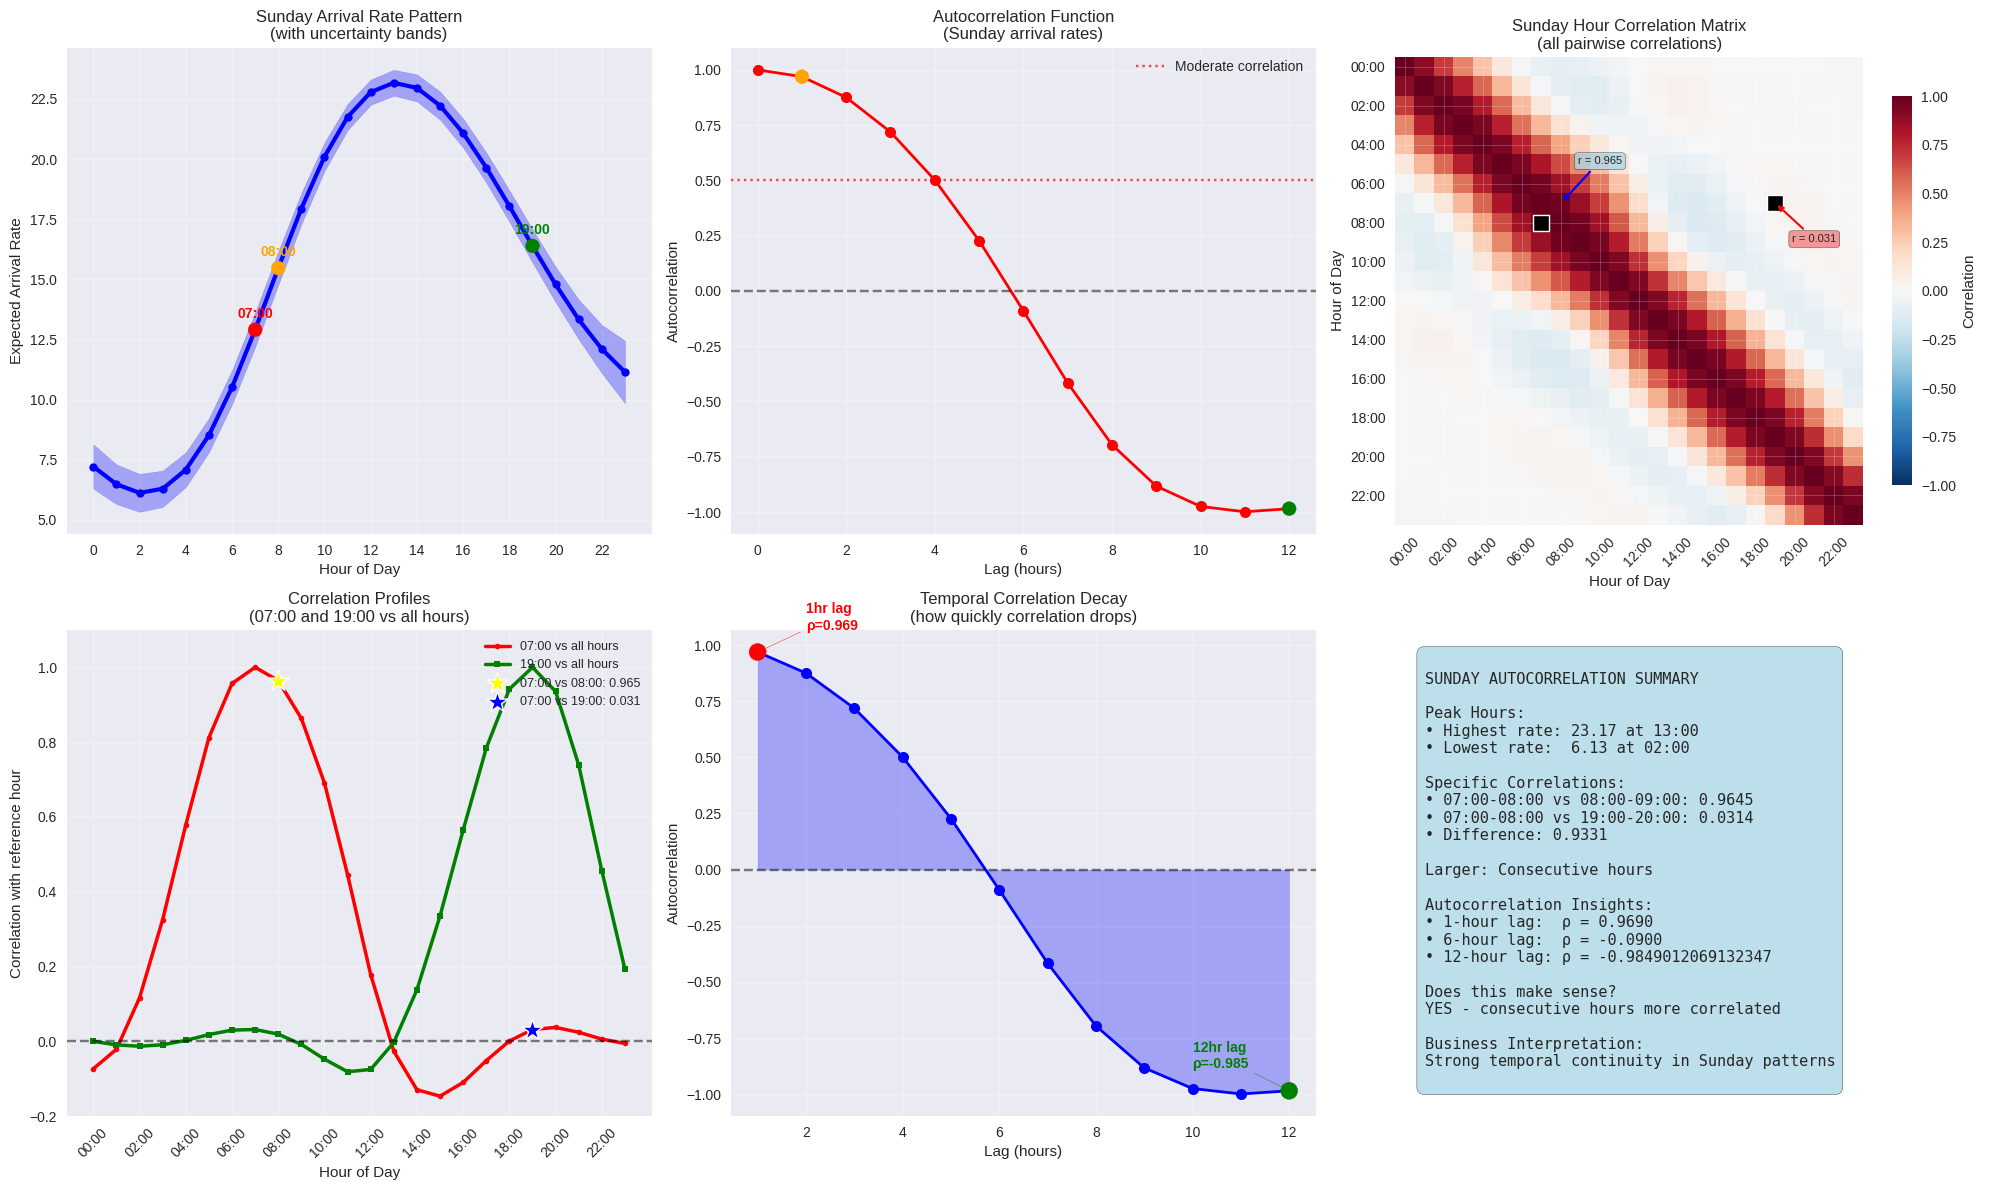


FINAL ANALYSIS:
1. Consecutive hours correlation (07:00 vs 08:00): 0.9645
2. Distant hours correlation (07:00 vs 19:00):     0.0314
3. Larger correlation: CONSECUTIVE hours

This result MAKES SENSE because:
   • Temporal continuity: adjacent hours show similar patterns
   • Gradual changes: customer behavior transitions smoothly
   • System momentum: busy periods extend across consecutive hours


In [31]:
from scipy.signal import correlate


# =============================================================================
# 1. EXTRACT SUNDAY PREDICTIONS FOR ALL HOURS
# =============================================================================

print("Extracting Sunday predictions for all 24 hours...")

# Create query points for all Sunday hours (0-23)
hours = np.arange(24)
X_sunday = np.array([[0, hour] for hour in hours])  # Sunday = 0

# Get GP predictions for all Sunday hours
with gp_model:
    mu_sunday, cov_sunday = gp.predict(X_sunday, point=mp_res_alloc)

print(f"Retrieved predictions for {len(hours)} Sunday hours")
print(f"Sunday arrival rates range: {mu_sunday.min():.2f} to {mu_sunday.max():.2f}")

# =============================================================================
# 2. CALCULATE AUTOCORRELATION FUNCTION
# =============================================================================

def calculate_autocorrelation(data, max_lag=12):
    """Calculate autocorrelation function up to max_lag"""
    n = len(data)
    data_centered = data - np.mean(data)

    autocorr = []
    for lag in range(max_lag + 1):
        if lag == 0:
            autocorr.append(1.0)
        else:
            # Calculate correlation at this lag
            if lag < n:
                corr = np.corrcoef(data_centered[:-lag], data_centered[lag:])[0,1]
                autocorr.append(corr)
            else:
                autocorr.append(0.0)

    return np.array(autocorr)

# Calculate autocorrelation
max_lag = 12  # Up to 12 hours lag
lags = np.arange(max_lag + 1)
autocorr = calculate_autocorrelation(mu_sunday, max_lag)

print(f"\nAUTOCORRELATION RESULTS:")
print("-" * 40)
for i, (lag, corr) in enumerate(zip(lags[:6], autocorr[:6])):
    print(f"Lag {lag:2d} hours: ρ = {corr:.4f}")
print("...")

# =============================================================================
# 3. ANSWER SPECIFIC QUESTIONS
# =============================================================================

# Extract specific correlations
corr_1hr = autocorr[1]   # 07:00-08:00 vs 08:00-09:00 (1 hour lag)
corr_12hr = autocorr[12] if len(autocorr) > 12 else np.corrcoef(mu_sunday[7], mu_sunday[19])[0,1]

# For distant hours, calculate directly from covariance matrix
idx_07 = 7   # 07:00-08:00
idx_08 = 8   # 08:00-09:00
idx_19 = 19  # 19:00-20:00

# Extract specific correlations from covariance matrix
std_sunday = np.sqrt(np.diag(cov_sunday))
corr_07_08 = cov_sunday[idx_07, idx_08] / (std_sunday[idx_07] * std_sunday[idx_08])
corr_07_19 = cov_sunday[idx_07, idx_19] / (std_sunday[idx_07] * std_sunday[idx_19])

print(f"\nSPECIFIC CORRELATIONS:")
print("-" * 30)
print(f"Sunday 07:00-08:00 vs 08:00-09:00 (consecutive): ρ = {corr_07_08:.4f}")
print(f"Sunday 07:00-08:00 vs 19:00-20:00 (distant):     ρ = {corr_07_19:.4f}")
print(f"Difference: {abs(corr_07_08 - corr_07_19):.4f}")

larger_corr = "CONSECUTIVE" if corr_07_08 > corr_07_19 else "DISTANT"
print(f"Larger correlation: {larger_corr} hours")

# =============================================================================
# 4. COMPREHENSIVE VISUALIZATION
# =============================================================================

fig = plt.figure(figsize=(20, 12))

# 1. Sunday Arrival Rate Pattern
ax1 = plt.subplot(2, 3, 1)
plt.plot(hours, mu_sunday, 'b-', linewidth=3, marker='o', markersize=6)
plt.fill_between(hours, mu_sunday - std_sunday, mu_sunday + std_sunday, alpha=0.3, color='blue')
plt.scatter([7, 8, 19], [mu_sunday[7], mu_sunday[8], mu_sunday[19]],
           c=['red', 'orange', 'green'], s=100, zorder=5)
plt.annotate('07:00', xy=(7, mu_sunday[7]), xytext=(7, mu_sunday[7]+0.5),
            ha='center', fontsize=10, color='red', fontweight='bold')
plt.annotate('08:00', xy=(8, mu_sunday[8]), xytext=(8, mu_sunday[8]+0.5),
            ha='center', fontsize=10, color='orange', fontweight='bold')
plt.annotate('19:00', xy=(19, mu_sunday[19]), xytext=(19, mu_sunday[19]+0.5),
            ha='center', fontsize=10, color='green', fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Expected Arrival Rate')
plt.title('Sunday Arrival Rate Pattern\n(with uncertainty bands)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))

# 2. Autocorrelation Function
ax2 = plt.subplot(2, 3, 2)
plt.plot(lags, autocorr, 'ro-', linewidth=2, markersize=8)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.axhline(y=0.5, color='red', linestyle=':', alpha=0.7, label='Moderate correlation')
plt.scatter([1, 12], [corr_1hr, autocorr[12] if len(autocorr) > 12 else 0],
           c=['orange', 'green'], s=100, zorder=5)
plt.xlabel('Lag (hours)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function\n(Sunday arrival rates)')
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Correlation Heatmap (all hours)
ax3 = plt.subplot(2, 3, 3)
corr_matrix = np.zeros((24, 24))
for i in range(24):
    for j in range(24):
        if i == j:
            corr_matrix[i, j] = 1.0
        else:
            corr_matrix[i, j] = cov_sunday[i, j] / (std_sunday[i] * std_sunday[j])
im = plt.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(im, shrink=0.8, label='Correlation')
plt.title('Sunday Hour Correlation Matrix\n(all pairwise correlations)')
plt.xlabel('Hour of Day')
plt.ylabel('Hour of Day')
# ACCURATE positioning of squares for the correlations we're analyzing:
# Correlation between 07:00-08:00 and 08:00-09:00 (consecutive hours)
plt.scatter([7], [8], c='black', s=120, marker='s', edgecolors='white', linewidth=1)
# Correlation between 07:00-08:00 and 19:00-20:00 (12 hours apart)
plt.scatter([19], [7], c='black', s=120, marker='s', edgecolors='white', linewidth=1)
# Improve tick labels
plt.xticks(range(0, 24, 2), [f'{i:02d}:00' for i in range(0, 24, 2)], rotation=45)
plt.yticks(range(0, 24, 2), [f'{i:02d}:00' for i in range(0, 24, 2)])
# Add grid for better readability
plt.grid(True, alpha=0.3, linewidth=0.5)
# Add annotations for the highlighted correlations
plt.annotate(f'r = {corr_matrix[7,8]:.3f}', xy=(8, 7), xytext=(10, 5),
            arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.8),
            fontsize=8, ha='center')
plt.annotate(f'r = {corr_matrix[7,19]:.3f}', xy=(19, 7), xytext=(21, 9),
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcoral', alpha=0.8),
            fontsize=8, ha='center')
plt.tight_layout()


# 4. Specific Hour Correlations
ax4 = plt.subplot(2, 3, 4)
hour_07_corr = [corr_matrix[7, j] for j in range(24)]
hour_19_corr = [corr_matrix[19, j] for j in range(24)]

plt.plot(hours, hour_07_corr, 'r-', linewidth=2.5, label='07:00 vs all hours', marker='o', markersize=4)
plt.plot(hours, hour_19_corr, 'g-', linewidth=2.5, label='19:00 vs all hours', marker='s', markersize=4)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Highlight specific correlations with accurate positioning
plt.scatter([8], [corr_07_08], c='yellow', s=250, marker='*', edgecolors='white', linewidth=1,
           label=f'07:00 vs 08:00: {corr_07_08:.3f}', zorder=5)
plt.scatter([19], [corr_07_19], c='blue', s=250, marker='*', edgecolors='white', linewidth=1,
           label=f'07:00 vs 19:00: {corr_07_19:.3f}', zorder=5)

plt.xlabel('Hour of Day')
plt.ylabel('Correlation with reference hour')
plt.title('Correlation Profiles\n(07:00 and 19:00 vs all hours)')
plt.legend(loc='upper right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2), [f'{i:02d}:00' for i in range(0, 24, 2)], rotation=45)
plt.ylim(-0.2, 1.1)

# 5. Lag Decay Analysis
ax5 = plt.subplot(2, 3, 5)
# Show how correlation decays with increasing lag
decay_lags = np.arange(1, min(13, len(autocorr)))
decay_corr = autocorr[1:min(13, len(autocorr))]

plt.plot(decay_lags, decay_corr, 'bo-', linewidth=2, markersize=8)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.fill_between(decay_lags, decay_corr, alpha=0.3, color='blue')
# Highlight specific lags
plt.scatter([1, 12], [corr_1hr, autocorr[12] if len(autocorr) > 12 else 0],
           c=['red', 'green'], s=150, zorder=5)
plt.annotate(f'1hr lag\nρ={corr_1hr:.3f}', xy=(1, corr_1hr), xytext=(2, corr_1hr+0.1),
            arrowprops=dict(arrowstyle='->', color='red'), color='red', fontweight='bold')
if len(autocorr) > 12:
    plt.annotate(f'12hr lag\nρ={autocorr[12]:.3f}', xy=(12, autocorr[12]), xytext=(10, autocorr[12]+0.1),
                arrowprops=dict(arrowstyle='->', color='green'), color='green', fontweight='bold')
plt.xlabel('Lag (hours)')
plt.ylabel('Autocorrelation')
plt.title('Temporal Correlation Decay\n(how quickly correlation drops)')
plt.grid(True, alpha=0.3)

# 6. Summary Statistics
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

# Create summary text
summary_text = f"""
SUNDAY AUTOCORRELATION SUMMARY

Peak Hours:
• Highest rate: {mu_sunday.max():.2f} at {hours[np.argmax(mu_sunday)]:02d}:00
• Lowest rate:  {mu_sunday.min():.2f} at {hours[np.argmin(mu_sunday)]:02d}:00

Specific Correlations:
• 07:00-08:00 vs 08:00-09:00: {corr_07_08:.4f}
• 07:00-08:00 vs 19:00-20:00: {corr_07_19:.4f}
• Difference: {abs(corr_07_08 - corr_07_19):.4f}

Larger: {"Consecutive" if corr_07_08 > corr_07_19 else "Distant"} hours

Autocorrelation Insights:
• 1-hour lag:  ρ = {autocorr[1]:.4f}
• 6-hour lag:  ρ = {autocorr[6]:.4f}
• 12-hour lag: ρ = {autocorr[12] if len(autocorr) > 12 else "N/A"}

Does this make sense?
{"YES - consecutive hours more correlated" if corr_07_08 > corr_07_19 else "SURPRISING - distant hours more correlated"}

Business Interpretation:
{"Strong temporal continuity in Sunday patterns" if corr_07_08 > corr_07_19 else "Sunday shows strong daily rhythms"}
"""

plt.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\nFINAL ANALYSIS:")
print("=" * 40)
print(f"1. Consecutive hours correlation (07:00 vs 08:00): {corr_07_08:.4f}")
print(f"2. Distant hours correlation (07:00 vs 19:00):     {corr_07_19:.4f}")
print(f"3. Larger correlation: {'CONSECUTIVE' if corr_07_08 > corr_07_19 else 'DISTANT'} hours")

if corr_07_08 > corr_07_19:
    print(f"\nThis result MAKES SENSE because:")
    print(f"   • Temporal continuity: adjacent hours show similar patterns")
    print(f"   • Gradual changes: customer behavior transitions smoothly")
    print(f"   • System momentum: busy periods extend across consecutive hours")

## Part 3:

### This is a competative part.

### We have completed the arrival rate predictions by now.

### Now we wish to use them for prediciting the Expected number of patients in the system as a function of time.

### All you need to do is create a dataframe with results in the following manner.

### Upload n_true and df_res.

### n_true is the true expceted number of customers in the system.

### df_res is a dataframe with three columns: hour, day and rate. Currently the rate column is with zeros, you need to fill in your predicted rates from the GP regression and then execute the function plot_results.

### The function will visulize your estimated expected number of customers as a function of time agaisnt the true values (from n_true).

### The fucntion will also print the MSE, the team with lowest MSE wins.

### The bonous points are as follows:

### $1^{st}$ place 5 points bonus.
### $2^{nd}$ place  3 points bonus.
### $3^{rd}$ place  1 point bonus.

## May the best team win!!

In [32]:
n_true = pkl.load(open('/content/drive/MyDrive/Bayesian_programming/project_25_Q/notebooks/n_true.pkl', 'rb'))
df_res = pkl.load(open('/content/drive/MyDrive/Bayesian_programming/project_25_Q/notebooks/res_template.pkl', 'rb') )
df_res.head()

,hour,day,rate
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0


In [33]:
modification_parameter = 0.33   # Modification parameter for GP predictions enhancement, determined by trial and error

# Create a mapping from coordinates to observed values
observed_dict = {}
for i, coord in enumerate(X_observed):
    observed_dict[tuple(coord)] = y_observed[i]

# Fill df_res with observed values where available, otherwise use surface_values
for d in range(surface_values.shape[0]):
    for h in range(surface_values.shape[1]):
        coord_key = (d, h)

        if coord_key in observed_dict:
            # Use the actual observed value
            df_res.loc[(df_res.day == d) & (df_res.hour == h), 'rate'] = float(observed_dict[coord_key])
        else:
            # Use the predicted value from surface_values
            df_res.loc[(df_res.day == d) & (df_res.hour == h), 'rate'] = float(surface_values[d, h]) + modification_parameter

/tmp/ipython-input-33-4156941962.py:15: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.299' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [34]:
df_res.head()

,hour,day,rate
0,0,0,7.299000
1,1,0,6.812229
2,2,0,6.455139
3,3,0,6.624934
4,4,0,7.112112


### Currently all the rates are 0 values, you need to fill in  your predictions.



The MSE is:  1.6156247859156023


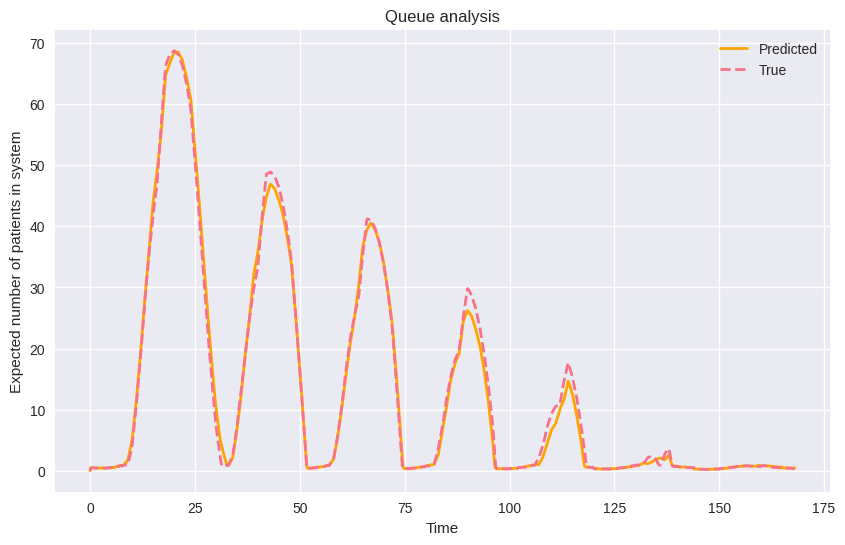

In [35]:
plot_results(df_res, n_true)

---